--------------------------------------------------
SIMULATION: SOP 3 - Inaccuracy of RGB vs Lab
--------------------------------------------------
Comparing Color 1 (Red [200, 10, 10]) vs Color 2 (Red [205, 15, 15])...
  > RGB Euclidean Distance: 8.66
  > CIE Lab Delta E:        1.55
  > Human Perception:       Imperceptible / Nearly Identical
--------------------------------------------------
Original Palette Size: 5 colors
Proposed Palette Size: 3 colors (Duplicates Removed)


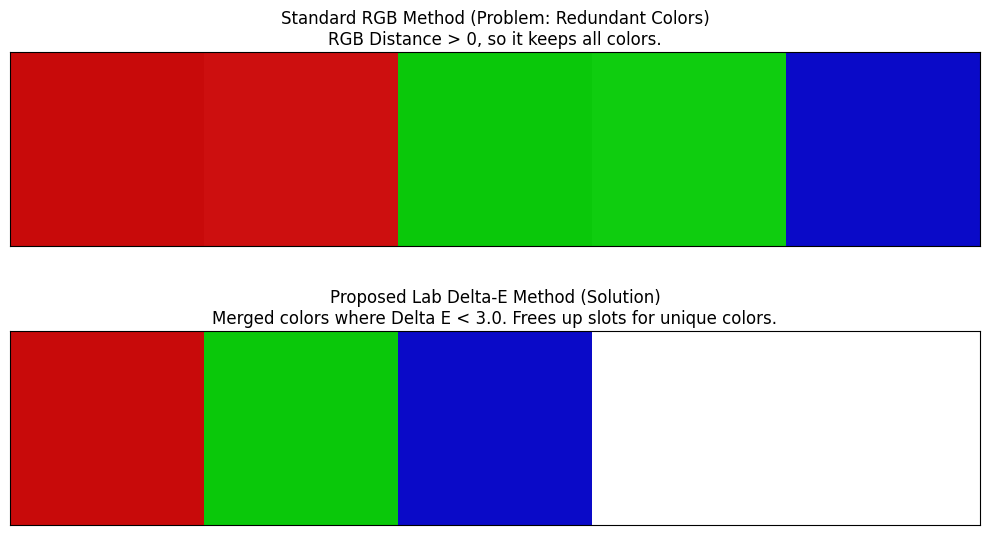

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# ==========================================
# PART 1: MATH & CONVERSION LOGIC
# ==========================================

def rgb_to_lab(r, g, b):
    """
    Manually converts RGB to CIE Lab to avoid external heavy dependencies (like skimage)
    for this specific demo. Assumes sRGB and D65 Illuminant.
    """
    # 1. Linearize RGB
    r, g, b = r/255.0, g/255.0, b/255.0
    r = ((r + 0.055) / 1.055) ** 2.4 if r > 0.04045 else r / 12.92
    g = ((g + 0.055) / 1.055) ** 2.4 if g > 0.04045 else g / 12.92
    b = ((b + 0.055) / 1.055) ** 2.4 if b > 0.04045 else b / 12.92

    # 2. RGB to XYZ
    X = r * 0.4124 + g * 0.3576 + b * 0.1805
    Y = r * 0.2126 + g * 0.7152 + b * 0.0722
    Z = r * 0.0193 + g * 0.1192 + b * 0.9505

    # 3. XYZ to Lab (D65 Ref)
    Xn, Yn, Zn = 0.95047, 1.00000, 1.08883
    X, Y, Z = X/Xn, Y/Yn, Z/Zn

    fx = X ** (1/3) if X > 0.008856 else (7.787 * X) + (16/116)
    fy = Y ** (1/3) if Y > 0.008856 else (7.787 * Y) + (16/116)
    fz = Z ** (1/3) if Z > 0.008856 else (7.787 * Z) + (16/116)

    L = (116 * fy) - 16
    a = 500 * (fx - fy)
    b_val = 200 * (fy - fz)
    
    return L, a, b_val

def calc_rgb_distance(c1, c2):
    """Standard Euclidean Distance in RGB space"""
    return sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2)

def calc_delta_e(c1, c2):
    """CIE76 Delta E Calculation (Euclidean distance in Lab space)"""
    l1, a1, b1 = rgb_to_lab(*c1)
    l2, a2, b2 = rgb_to_lab(*c2)
    return sqrt((l1-l2)**2 + (a1-a2)**2 + (b1-b2)**2)

# ==========================================
# PART 2: THE SIMULATION SCENARIO
# ==========================================

# We simulate a palette generated by a standard "bad" algorithm.
# Notice color 1 and 2 are almost identical reds.
# Notice color 3 and 4 are almost identical greens.
mock_palette_rgb = [
    [200, 10, 10],   # Deep Red
    [205, 15, 15],   # Slightly Lighter Red (Looks same to eye)
    [10, 200, 10],   # Green
    [15, 205, 15],   # Slightly Lighter Green (Looks same to eye)
    [10, 10, 200]    # Blue
]

print("-" * 50)
print("SIMULATION: SOP 3 - Inaccuracy of RGB vs Lab")
print("-" * 50)

# THRESHOLDS
# An RGB distance of 10-15 is mathematically significant to a computer.
# A Delta E of < 2.3 is usually considered the "Just Noticeable Difference" (JND).
RGB_THRESHOLD = 0.0 # Standard K-Means usually doesn't merge unless identical
DELTA_E_THRESHOLD = 3.0 # We want to merge anything not easily distinguishable

optimized_palette = []
ignored_indices = []

# Logic: Compare every color to the first one to see if we should merge them
print(f"Comparing Color 1 (Red {mock_palette_rgb[0]}) vs Color 2 (Red {mock_palette_rgb[1]})...")

rgb_dist = calc_rgb_distance(mock_palette_rgb[0], mock_palette_rgb[1])
delta_e = calc_delta_e(mock_palette_rgb[0], mock_palette_rgb[1])

print(f"  > RGB Euclidean Distance: {rgb_dist:.2f}")
print(f"  > CIE Lab Delta E:        {delta_e:.2f}")

if delta_e < 2.0:
    perception = "Imperceptible / Nearly Identical"
elif delta_e < 10.0:
    perception = "Hard to distinguish"
else:
    perception = "Clearly different"

print(f"  > Human Perception:       {perception}")
print("-" * 50)

# ==========================================
# PART 3: APPLYING THE ALGORITHMS
# ==========================================

# 1. Standard Method (keeps everything different)
standard_palette = mock_palette_rgb 

# 2. Proposed Method (Filters based on Delta E)
proposed_palette = []
for color in mock_palette_rgb:
    is_duplicate = False
    for existing in proposed_palette:
        d_e = calc_delta_e(color, existing)
        if d_e < DELTA_E_THRESHOLD:
            is_duplicate = True
            break
    if not is_duplicate:
        proposed_palette.append(color)

print(f"Original Palette Size: {len(standard_palette)} colors")
print(f"Proposed Palette Size: {len(proposed_palette)} colors (Duplicates Removed)")

# ==========================================
# PART 4: VISUALIZATION
# ==========================================

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Helper to normalize for matplotlib
def norm_colors(palette):
    return [[c[0]/255, c[1]/255, c[2]/255] for c in palette]

# Plot Standard
ax[0].imshow([norm_colors(standard_palette)])
ax[0].set_title(f"Standard RGB Method (Problem: Redundant Colors)\nRGB Distance > 0, so it keeps all colors.")
ax[0].set_xticks([])
ax[0].set_yticks([])

# Plot Proposed
# Fill the rest with white just for visual alignment if list is shorter
display_proposed = norm_colors(proposed_palette)
while len(display_proposed) < len(standard_palette):
    display_proposed.append([1, 1, 1]) # White padding

ax[1].imshow([display_proposed])
ax[1].set_title(f"Proposed Lab Delta-E Method (Solution)\nMerged colors where Delta E < {DELTA_E_THRESHOLD}. Frees up slots for unique colors.")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
plt.show()